# An In-Depth Look at Spotify and Music Trends Over the Past Two Decades

By Gordon Tran (gt294), Alyssa Zhang (az354), Leonardo Park (lsp62), and Jonna Chen (jc2627)

## Introduction

As avid music listeners, we were curious as to how music trends and attributes have changed over the years. Using Spotify's API, we hoped to be able to find and visualize any changes that have occurred in the music industry over mainly the last two decades. Spotify Wrapped gives individual users a look at how they've listened to music via Spotify services, but we wanted to give a holistic analysis of the songs, among qualities like valence, tempo, acousticness, etc., in Spotify's API.

Specifically, our research question is as stated below:

### Research Question: Observing the top artists of the past two decades, how have music trends and characteristics changed over the years? 

For example, is there a clear relation between energy and loudness of songs in each decade? And does that relationship stay true across the decades?

### Summary of Our Results

Through creating many plots, graphs and hypothesis testing, there were our results:
- In the 2010s decade, songs tended to have less valence, meaining they sounded overall less happy
- In the 2010s decade, songs tended to be more in minor keys
- In the 2010s era, songs tended have a higher tempo, as indicated by the higher average tempo value.
- In the 2010s era, songs tended to be less speechy
- In the 2010s decade, songs tended to be more acoustic, more raw instrumentals
- In the 2010s decade, songs tended to be more danceable

# Scraping our Data

In [179]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from scipy import stats
from scipy.stats import poisson, ttest_ind

CLIENT_ID = '64fa5e7364b5468993774e8c2beebead'
CLIENT_SECRET = '0c33a7335c614b419f0faa3668033235'

Here, we are posting a request to get data from the Spotify API, and getting the data with a GET request. 

In [107]:
AUTH_URL = 'https://accounts.spotify.com/api/token'
# POST
auth_response = requests.post(AUTH_URL, {
    'grant_type': 'client_credentials',
    'client_id': CLIENT_ID,
    'client_secret': CLIENT_SECRET,
})

# convert the response to JSON
auth_response_data = auth_response.json()

# save the access token
access_token = auth_response_data['access_token']

headers = {
    'Authorization': 'Bearer {token}'.format(token=access_token)
}

# base URL of all Spotify API endpoints
BASE_URL = 'https://api.spotify.com/v1/'

# Track ID from the URI
track_id = '6y0igZArWVi6Iz0rj35c1Y'

# actual GET request with proper header
r = requests.get(BASE_URL + 'audio-features/' + track_id, headers=headers)

We wrote some functions to make it easier to make calls on different artists and sift through the data we just obtained from the Spotify API.

In [108]:
def artistjson(id):
    
    artist_id = id

    # pull all artists albums
    r = requests.get(BASE_URL + 'artists/' + artist_id + '/albums', 
                     headers=headers, 
                     params={'include_groups': 'album', 'limit': 50})
    return r.json()

In [109]:
def printAlbums(id):
    artist_id = id
    # pull all artists albums
    r = requests.get(BASE_URL + 'artists/' + artist_id + '/albums', 
                 headers=headers, 
                 params={'include_groups': 'album', 'limit': 50})
    d = r.json()
    for album in d['items']:
        print(album['name'], ' --- ', album['release_date'])

In [110]:
def getTracksInAlbum(ajson):
    
    data = []   # will hold all track info
    albums = [] # to keep track of duplicates

    # loop over albums and get all tracks
    for album in ajson['items']:
        album_name = album['name']

        # here's a hacky way to skip over albums we've already grabbed
        trim_name = album_name.split('(')[0].strip()
        if trim_name.upper() in albums:
            continue
        albums.append(trim_name.upper()) # use upper() to standardize
    
        # this takes a few seconds so let's keep track of progress    
        print(album_name)
    
        # pull all tracks from this album
        r = requests.get(BASE_URL + 'albums/' + album['id'] + '/tracks', 
            headers=headers)
        tracks = r.json()['items']
    
        for track in tracks:
            # get audio features (key, liveness, danceability, ...)
            f = requests.get(BASE_URL + 'audio-features/' + track['id'], 
                headers=headers)
            f = f.json()
        
            # combine with album info
            f.update({
                'track_name': track['name'],
                'album_name': album_name,
                'short_album_name': trim_name,
                'release_date': album['release_date'],
                'album_id': album['id']
            })
        
            data.append(f)
    return data

The top 10 artists of the 2010s are indicative of the musical tastes popular of the 2010s musical era. According to Billboard, these are the top 10 artists of the 2010 decade. (https://www.billboard.com/articles/columns/pop-shop/6443462/best-artists-of-2010s-so-far). We found the Spotify IDs of these artists and the artist's JSON. 

In [6]:
# top artists of 2010s
kendrick_id ='2YZyLoL8N0Wb9xBt1NhZWg'
arcadefire_id ='3kjuyTCjPG1WMFCiyc5IuB'
katy_id = '6jJ0s89eD6GaHleKKya26X'
gaga_id = '1HY2Jd0NmPuamShAr6KMms'
nicki_id= '0hCNtLu0JehylgoiP8L4Gh'
drake_id = '3TVXtAsR1Inumwj472S9r4'
taylor_id = '06HL4z0CvFAxyc27GXpf02'
adele_id = '4dpARuHxo51G3z768sgnrY'
kanye_id = '5K4W6rqBFWDnAN6FQUkS6x'
beyonce_id ='6vWDO969PvNqNYHIOW5v0m'

kendrick = artistjson(kendrick_id)
arcadefire= artistjson(arcadefire_id)
katy = artistjson(katy_id)
gaga = artistjson(gaga_id)
nicki = artistjson(nicki_id)
drake = artistjson(drake_id)
taylor = artistjson(taylor_id)
adele = artistjson(adele_id)
kanye = artistjson(kanye_id)
beyonce =artistjson(beyonce_id)

The top 10 artists of the 2000s are indicative of the musical tastes popular of the 2000s musical era. According to Billboard, these are the top 10 artists of the 2000 decade. (https://www.billboard.com/articles/news/266420/artists-of-the-decade). We found the Spotify IDs of these artists and the artist's JSON as well. 

In [112]:
# top artists of 2000s
eminem_id = '7dGJo4pcD2V6oG8kP0tJRR'
usher_id = '23zg3TcAtWQy7J6upgbUnj'
nelly_id = '2gBjLmx6zQnFGQJCAQpRgw'
alicia_id = '3DiDSECUqqY1AuBP8qtaIa'
#beyonce is also in this data set
cent50_id = '3q7HBObVc0L8jNeTe5Gofh'
nickelback_id = '6deZN1bslXzeGvOLaLMOIF'
britney_id = '26dSoYclwsYLMAKD3tpOr4'
dchild_id = '1Y8cdNmUJH7yBTd9yOvr5i'
jz_id = '3nFkdlSjzX9mRTtwJOzDYB'


eminem = artistjson(eminem_id)
usher= artistjson(usher_id)
nelly = artistjson(nelly_id)
alicia = artistjson(alicia_id)
#beyonce is also in this data set
cent50 = artistjson(cent50_id)
nickelback = artistjson(nickelback_id)
britney = artistjson(britney_id)
dchild = artistjson(dchild_id)
jz = artistjson(jz_id)

We need to get the tracks in the albums of each of these artists in order to get the data about their songs. 

In [9]:
# getting tracks of 2010s top artists
dfkendrick = getTracksInAlbum(kendrick)
dfaf = getTracksInAlbum(arcadefire)
dfkaty = getTracksInAlbum(katy)
dfgaga = getTracksInAlbum(gaga)
dfnicki = getTracksInAlbum(nicki)
dfdrake = getTracksInAlbum(drake)
dftaylor = getTracksInAlbum(taylor)
dfadele = getTracksInAlbum(adele)
dfkanye = getTracksInAlbum(kanye)
dfbeyonce = getTracksInAlbum(beyonce)

Black Panther The Album Music From And Inspired By
DAMN. COLLECTORS EDITION.
DAMN.
untitled unmastered.
To Pimp A Butterfly
good kid, m.A.A.d city (Deluxe)
Section.80
Overly Dedicated
Everything Now
Reflektor (Deluxe)
The Suburbs (Deluxe)
Neon Bible
Funeral
Smile
Witness (Deluxe)
PRISM (Deluxe)
Katy Perry - Teenage Dream: The Complete Confection
Teenage Dream: The Complete Confection
Teenage Dream
Unplugged (Live At MTV Unplugged, New York, NY/2009)
One Of The Boys
Chromatica
A Star Is Born Soundtrack
Joanne (Deluxe)
Cheek To Cheek (Deluxe)
ARTPOP
Born This Way (International Special Edition Version)
Born This Way - The Remix
The Fame Monster
The Fame
Queen (Deluxe)
The Pinkprint (Deluxe Edition)
Pink Friday ... Roman Reloaded (Deluxe Edition)
Pink Friday: Roman Reloaded The Re-Up
Pink Friday (Japan Version)
Dark Lane Demo Tapes
Care Package
So Far Gone
Scorpion
More Life
Views
What A Time To Be Alive
If You're Reading This It's Too Late
Nothing Was The Same (Deluxe)
Take Care (Deluxe)

In [113]:
# getting tracks of 2000s top artists
dfeminem = getTracksInAlbum(eminem)
dfusher = getTracksInAlbum(usher)
dfnelly = getTracksInAlbum(nelly)
dfalicia = getTracksInAlbum(alicia)
# beyonce already has a df with tracks in album
dfcent50 = getTracksInAlbum(cent50)
dfnickelback = getTracksInAlbum(nickelback)
dfbritney = getTracksInAlbum(britney)
dfdchild = getTracksInAlbum(dchild)
dfjz = getTracksInAlbum(jz)

Music To Be Murdered By
Kamikaze
Revival
The Marshall Mathers LP2 (Deluxe)
Recovery (Deluxe Edition)
Relapse: Refill
Relapse (Deluxe Edition)
Relapse [Deluxe]
Eminem Presents The Re-Up
Encore (Deluxe Version)
The Eminem Show
The Marshall Mathers LP
The Slim Shady LP (Expanded Edition)
"A"
Hard II Love
Looking 4 Myself (Expanded Edition)
Versus
Raymond v Raymond (Expanded Edition)
Here I Stand
Confessions (Expanded Edition)
8701
Live
My Way
Usher
Country Grammar (Deluxe Edition)
Nelly Collabs
Nelly Slow Jams
Nelly Party Anthems
M.O. (Deluxe Edition)
5.0 Deluxe
5.0
Brass Knuckles
Sweatsuit
Sweat
Suit
Da Derrty Versions: The Re-invention
Nellyville
ALICIA
HERE
Alicia Keys - VH1 Storytellers
Girl On Fire
The Element Of Freedom
As I Am (Expanded Edition)
Unplugged
The Diary Of Alicia Keys (Expanded Edition)
Songs In A Minor (Expanded Edition)
Solid Gold Rhymes
Thug Songs
The Complete G-Unit
Animal Ambition: An Untamed Desire To Win
Before I Self-Destruct
Bullet Proof
Curtis
Live At The Hard

Next, we put our json responses into dataframes so we can manipulate the data!

In [13]:
dfkendrick = pd.DataFrame(dfkendrick)
dfaf = pd.DataFrame(dfaf)
dfkaty = pd.DataFrame(dfkaty)
dfgaga = pd.DataFrame(dfgaga)
dfnicki = pd.DataFrame(dfnicki)
dfdrake = pd.DataFrame(dfdrake)
dftaylor = pd.DataFrame(dftaylor)
dfadele = pd.DataFrame(dfadele)
dfkanye = pd.DataFrame(dfkanye)
dfbeyonce = pd.DataFrame(dfbeyonce)

In [114]:
dfeminem = pd.DataFrame(dfeminem)
dfusher = pd.DataFrame(dfusher)
dfnelly = pd.DataFrame(dfnelly)
dfalicia = pd.DataFrame(dfalicia)
#dfbeyonce goes here
dfcent50 = pd.DataFrame(dfcent50)
dfnickelback = pd.DataFrame(dfnickelback)
dfbritney = pd.DataFrame(dfbritney)
dfdchild = pd.DataFrame(dfdchild)
dfjz = pd.DataFrame(dfjz)

Here, we clean our data. We change the date string into a datetime object, remove any special versions of songs, and remove any duplicate songs. 

In [15]:
dfkendrick['release_date'] = pd.to_datetime(dfkendrick['release_date'])
dfkendrick = dfkendrick.sort_values(by='track_name')
#get rid of live album, remixes, vocal tracks, ...
dfkendrick = dfkendrick[~dfkendrick['track_name'].str.contains('Concert|Remix|Karaoke|Instrumental|Extended')]
dfkendrick = dfkendrick.drop_duplicates(subset=['track_name'])

dfaf['release_date'] = pd.to_datetime(dfaf['release_date'])
dfaf = dfaf.sort_values(by='track_name')
#get rid of live album, remixes, vocal tracks, ...
dfaf = dfaf[~dfaf['track_name'].str.contains('Concert|Remix|Karaoke|Instrumental|Extended')]
dfaf = dfaf.drop_duplicates(subset=['track_name'])

dfkaty['release_date'] = pd.to_datetime(dfkaty['release_date'])
dfkaty = dfkaty.sort_values(by='track_name')
#get rid of live album, remixes, vocal tracks, ...
dfkaty = dfkaty[~dfkaty['track_name'].str.contains('Concert|Remix|Karaoke|Instrumental|Extended')]
dfkaty = dfkaty.drop_duplicates(subset=['track_name'])

dfgaga['release_date'] = pd.to_datetime(dfgaga['release_date'])
dfgaga = dfgaga.sort_values(by='track_name')
#get rid of live album, remixes, vocal tracks, ...
dfgaga = dfgaga[~dfgaga['track_name'].str.contains('Concert|Remix|Karaoke|Instrumental|Extended')]
dfgaga = dfgaga.drop_duplicates(subset=['track_name'])

dfnicki['release_date'] = pd.to_datetime(dfnicki['release_date'])
dfnicki = dfnicki.sort_values(by='track_name')
#get rid of live album, remixes, vocal tracks, ...
dfnicki = dfnicki[~dfnicki['track_name'].str.contains('Concert|Remix|Karaoke|Instrumental|Extended')]
dfnicki = dfnicki.drop_duplicates(subset=['track_name'])

dfdrake['release_date'] = pd.to_datetime(dfdrake['release_date'])
dfdrake = dfdrake.sort_values(by='track_name')
#get rid of live album, remixes, vocal tracks, ...
dfdrake = dfdrake[~dfdrake['track_name'].str.contains('Concert|Remix|Karaoke|Instrumental|Extended')]
dfdrake = dfdrake.drop_duplicates(subset=['track_name'])

dftaylor['release_date'] = pd.to_datetime(dftaylor['release_date'])
dftaylor = dftaylor.sort_values(by='track_name')
#get rid of live album, remixes, vocal tracks, ...
dftaylor = dftaylor[~dftaylor['track_name'].str.contains('Concert|Remix|Karaoke|Instrumental|Extended')]
dftaylor = dftaylor.drop_duplicates(subset=['track_name'])

dfadele['release_date'] = pd.to_datetime(dfadele['release_date'])
dfadele = dfadele.sort_values(by='track_name')
#get rid of live album, remixes, vocal tracks, ...
dfadele = dfadele[~dfadele['track_name'].str.contains('Concert|Remix|Karaoke|Instrumental|Extended')]
dfadele = dfadele.drop_duplicates(subset=['track_name'])

dfkanye['release_date'] = pd.to_datetime(dfkanye['release_date'])
dfkanye = dfkendrick.sort_values(by='track_name')
#get rid of live album, remixes, vocal tracks, ...
dfkanye = dfkanye[~dfkanye['track_name'].str.contains('Concert|Remix|Karaoke|Instrumental|Extended')]
dfkanye = dfkanye.drop_duplicates(subset=['track_name'])

dfbeyonce['release_date'] = pd.to_datetime(dfbeyonce['release_date'])
dfbeyonce = dfbeyonce.sort_values(by='track_name')
#get rid of live album, remixes, vocal tracks, ...
dfbeyonce = dfbeyonce[~dfbeyonce['track_name'].str.contains('Concert|Remix|Karaoke|Instrumental|Extended')]
dfbeyonce = dfbeyonce.drop_duplicates(subset=['track_name'])

In [115]:
dfeminem['release_date'] = pd.to_datetime(dfeminem['release_date'])
dfeminem = dfeminem.sort_values(by='track_name')
#get rid of live album, remixes, vocal tracks, ...
dfeminem = dfeminem[~dfeminem['track_name'].str.contains('Concert|Remix|Karaoke|Instrumental|Extended')]
dfeminem = dfeminem.drop_duplicates(subset=['track_name'])

dfusher['release_date'] = pd.to_datetime(dfusher['release_date'])
dfusher = dfusher.sort_values(by='track_name')
#get rid of live album, remixes, vocal tracks, ...
dfusher = dfusher[~dfusher['track_name'].str.contains('Concert|Remix|Karaoke|Instrumental|Extended')]
dfusher = dfusher.drop_duplicates(subset=['track_name'])

dfnelly['release_date'] = pd.to_datetime(dfnelly['release_date'])
dfnelly = dfnelly.sort_values(by='track_name')
#get rid of live album, remixes, vocal tracks, ...
dfnelly = dfnelly[~dfnelly['track_name'].str.contains('Concert|Remix|Karaoke|Instrumental|Extended')]
dfnelly = dfnelly.drop_duplicates(subset=['track_name'])

dfalicia['release_date'] = pd.to_datetime(dfalicia['release_date'])
dfalicia = dfalicia.sort_values(by='track_name')
#get rid of live album, remixes, vocal tracks, ...
dfalicia = dfalicia[~dfalicia['track_name'].str.contains('Concert|Remix|Karaoke|Instrumental|Extended')]
dfalicia = dfalicia.drop_duplicates(subset=['track_name'])

# beyonce

dfcent50['release_date'] = pd.to_datetime(dfcent50['release_date'])
dfcent50 = dfcent50.sort_values(by='track_name')
#get rid of live album, remixes, vocal tracks, ...
dfcent50 = dfcent50[~dfcent50['track_name'].str.contains('Concert|Remix|Karaoke|Instrumental|Extended')]
dfcent50 = dfcent50.drop_duplicates(subset=['track_name'])

dfnickelback['release_date'] = pd.to_datetime(dfnickelback['release_date'])
dfnickelback = dfnickelback.sort_values(by='track_name')
#get rid of live album, remixes, vocal tracks, ...
dfnickelback = dfnickelback[~dfnickelback['track_name'].str.contains('Concert|Remix|Karaoke|Instrumental|Extended')]
dfnickelback = dfnickelback.drop_duplicates(subset=['track_name'])

dfbritney['release_date'] = pd.to_datetime(dfbritney['release_date'])
dfbritney = dfbritney.sort_values(by='track_name')
#get rid of live album, remixes, vocal tracks, ...
dfbritney = dfbritney[~dfbritney['track_name'].str.contains('Concert|Remix|Karaoke|Instrumental|Extended')]
dfbritney = dfbritney.drop_duplicates(subset=['track_name'])

dfdchild['release_date'] = pd.to_datetime(dfdchild['release_date'])
dfdchild = dfdchild.sort_values(by='track_name')
#get rid of live album, remixes, vocal tracks, ...
dfdchild = dfdchild[~dfdchild['track_name'].str.contains('Concert|Remix|Karaoke|Instrumental|Extended')]
dfdchild = dfdchild.drop_duplicates(subset=['track_name'])

dfjz['release_date'] = pd.to_datetime(dfjz['release_date'])
dfjz = dfjz.sort_values(by='track_name')
#get rid of live album, remixes, vocal tracks, ...
dfjz = dfjz[~dfjz['track_name'].str.contains('Concert|Remix|Karaoke|Instrumental|Extended')]
dfjz = dfjz.drop_duplicates(subset=['track_name'])

In [170]:
artists2010 = [dfkendrick, dfaf, dfkaty, dfgaga, dfnicki, dfdrake, dftaylor, dfadele, dfkanye, dfbeyonce]
artists2000 = [dfeminem, dfusher, dfnelly, dfbeyonce, dfalicia, dfcent50, dfnickelback, dfbritney, dfdchild, dfjz]

# Data Cleaning

Here we decide to merge together all our dataframes into one big dataframe that contains all the songs of artists who defined the the music of the decade!

In [171]:
joined2010s = dfkendrick
for a in artists2010:
    joined2010s = pd.concat([joined2010s, a], axis=0)
    
joined2000s = dfeminem
for a in artists2000:
    joined2000s = pd.concat([joined2000s, a], axis=0)

We do not need data about the url of the song on Spotify, the album id assigned by Spotify, the track_href, which is a link to the Web API endpoint providing full details of the track, and type, which is "audio-features" for every track. These are not integral to our data analysis.

In [172]:
# drop unnecessary columns
joined2010s = joined2010s.drop(columns = ["analysis_url", "album_id", "track_href", "type"])
joined2000s = joined2000s.drop(columns = ["analysis_url", "album_id", "track_href", "type"])

In [173]:
joined2010s.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'id', 'uri', 'duration_ms', 'time_signature', 'track_name',
       'album_name', 'short_album_name', 'release_date'],
      dtype='object')

These are the final columns of our dataframes!

In [174]:
joined2010s = joined2010s.sort_values(by='release_date')
joined2000s = joined2000s.sort_values(by='release_date')

In [175]:
joined2010s = joined2010s.loc[joined2010s['release_date'] > '2009-11-18']
joined2010s

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,uri,duration_ms,time_signature,track_name,album_name,short_album_name,release_date
181,0.482,0.907,8,-5.995,1,0.4190,0.09450,0.000000,0.1510,0.212,86.121,23Cx5Jv0bsCMoUnoygy5jy,spotify:track:23Cx5Jv0bsCMoUnoygy5jy,274147,4,Light Up,Thank Me Later (Int'l Version),Thank Me Later,2010-01-01
183,0.382,0.600,9,-6.881,0,0.0338,0.05440,0.000005,0.1150,0.226,95.126,147TR5QZzxTnnwqltaRi4N,spotify:track:147TR5QZzxTnnwqltaRi4N,154120,4,Cece's Interlude,Thank Me Later (Int'l Version),Thank Me Later,2010-01-01
182,0.429,0.864,2,-5.975,1,0.6040,0.08100,0.000000,0.3310,0.332,100.832,53VIWPPMz9S7ob0D8JxF9N,spotify:track:53VIWPPMz9S7ob0D8JxF9N,305520,5,Miss Me,Thank Me Later (Int'l Version),Thank Me Later,2010-01-01
175,0.325,0.848,7,-5.611,1,0.2790,0.01090,0.000000,0.1240,0.433,100.093,1EoHEkVcysf4WVDx6r9WzQ,spotify:track:1EoHEkVcysf4WVDx6r9WzQ,233560,5,Over,Thank Me Later (Int'l Version),Thank Me Later,2010-01-01
177,0.606,0.809,7,-4.667,1,0.2790,0.00778,0.000016,0.3360,0.272,156.337,55YHftnlehUQQJoTSLKCxj,spotify:track:55YHftnlehUQQJoTSLKCxj,234333,4,Up All Night,Thank Me Later (Int'l Version),Thank Me Later,2010-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,0.508,0.738,2,-5.126,0,0.0579,0.11900,0.000000,0.0558,0.523,158.131,2F20djOXWDSFEXu3tPdV71,spotify:track:2F20djOXWDSFEXu3tPdV71,178642,4,Not the End of the World,Smile,Smile,2020-08-28
10,0.710,0.460,0,-7.560,1,0.0492,0.29700,0.000000,0.1060,0.228,98.033,6lWp5O5XH6smTt4vzd4Mgy,spotify:track:6lWp5O5XH6smTt4vzd4Mgy,198725,4,Only Love,Smile,Smile,2020-08-28
2,0.616,0.659,7,-5.994,1,0.0404,0.10400,0.000000,0.0790,0.441,125.962,3i0uu4DEpcmEAudChpVDBh,spotify:track:3i0uu4DEpcmEAudChpVDBh,182595,4,Teary Eyes,Smile,Smile,2020-08-28
11,0.363,0.594,2,-7.847,1,0.0790,0.18400,0.000000,0.1060,0.257,94.639,2czhdHhprTLjvlIzj56jQt,spotify:track:2czhdHhprTLjvlIzj56jQt,131271,4,What Makes A Woman,Smile,Smile,2020-08-28


Here, we grouped by release dates of the tracks and took the mean values. We did this because this release date in out case is synonmymous to each album. We confirmed each album was released on different days, so we know each mean of the date is the same as the mean of each album. Grouping by date helped us preserve the date of release and would allow us to analyze their influence on the music market over the years.

In [176]:
joined2000s = joined2000s.loc[joined2000s['release_date'] > '1999-03-23']
joined2000s = joined2000s.loc[joined2000s['release_date'] < '2010-03-30']
joined2000s

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,uri,duration_ms,time_signature,track_name,album_name,short_album_name,release_date
41,0.568,0.375,5,-14.313,0,0.0734,0.24500,0.000060,0.4230,0.422,115.746,7F041vf9g86qJJO9J93LTr,spotify:track:7F041vf9g86qJJO9J93LTr,125620,4,Intro (The Writing's On The Wall),The Writing's On The Wall,The Writing's On The Wall,1999-09-07
51,0.775,0.677,1,-4.632,1,0.0582,0.00540,0.001890,0.0679,0.684,89.008,5Yb0SCzyJinUEfbfuREeV9,spotify:track:5Yb0SCzyJinUEfbfuREeV9,230200,4,"Jumpin', Jumpin'",The Writing's On The Wall,The Writing's On The Wall,1999-09-07
59,0.918,0.580,1,-3.767,1,0.0520,0.14400,0.000124,0.0402,0.761,132.667,0Fdr9rx5HyxtwNg611nOrZ,spotify:track:0Fdr9rx5HyxtwNg611nOrZ,225267,4,Independent Women Pt. II,The Writing's On The Wall,The Writing's On The Wall,1999-09-07
42,0.886,0.674,1,-4.922,0,0.2110,0.03670,0.000000,0.0369,0.622,97.940,2tPEU0AUk8ha6aSl4uHVMA,spotify:track:2tPEU0AUk8ha6aSl4uHVMA,193840,4,So Good,The Writing's On The Wall,The Writing's On The Wall,1999-09-07
47,0.661,0.607,5,-4.572,0,0.0297,0.00293,0.000016,0.0539,0.491,115.995,54GozwVOXrmMyPMenpTuCU,spotify:track:54GozwVOXrmMyPMenpTuCU,335389,4,Now That She's Gone,The Writing's On The Wall,The Writing's On The Wall,1999-09-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,0.743,0.630,1,-7.766,0,0.2490,0.29700,0.000177,0.1530,0.611,132.028,3fnpMcMbhrep8wMIjKsNVS,spotify:track:3fnpMcMbhrep8wMIjKsNVS,253133,3,Like the Sea,The Element Of Freedom,The Element Of Freedom,2009-12-15
64,0.622,0.506,7,-9.469,1,0.0269,0.36400,0.039500,0.1030,0.069,119.942,6JAzU3Vy6uxrnh2zAd0byh,spotify:track:6JAzU3Vy6uxrnh2zAd0byh,240213,4,Wait Til You See My Smile,The Element Of Freedom,The Element Of Freedom,2009-12-15
66,0.595,0.507,7,-7.892,1,0.0618,0.73200,0.000020,0.1060,0.337,86.099,4JOP8ELK6AaeySe7sKe996,spotify:track:4JOP8ELK6AaeySe7sKe996,249240,4,Un-thinkable (I'm Ready),The Element Of Freedom,The Element Of Freedom,2009-12-15
73,0.479,0.368,6,-7.784,1,0.0341,0.73900,0.000041,0.1180,0.142,92.959,5sra5UY6sD658OabHL3QtI,spotify:track:5sra5UY6sD658OabHL3QtI,216480,4,Empire State of Mind (Part II) Broken Down,The Element Of Freedom,The Element Of Freedom,2009-12-15


In [177]:
mean2010s = joined2010s.groupby(by = joined2010s["release_date"]).mean()

mean2010s.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
release_date,,,,,,,,,,,,,
2010-01-01,0.513769,0.756538,5.230769,-6.202769,0.538462,0.269600,0.206391,0.000002,0.166108,0.428785,105.722769,264668.769231,4.153846
2010-07-01,0.458667,0.722467,5.833333,-7.246611,0.722222,0.044000,0.195132,0.227950,0.180922,0.422517,128.051722,248366.000000,3.833333
2010-08-24,0.662143,0.722857,4.714286,-5.407857,0.714286,0.053400,0.024459,0.000051,0.154100,0.575714,129.987143,233834.857143,4.000000
2010-09-14,0.638455,0.709727,6.363636,-6.836455,0.636364,0.318427,0.288827,0.007593,0.248064,0.473727,111.874364,274720.636364,4.090909
2010-10-25,0.488107,0.646571,5.571429,-6.264429,0.892857,0.039732,0.209634,0.000082,0.508668,0.345286,126.435000,295615.714286,3.892857


In [178]:
mean2000s = joined2000s.groupby(by = joined2000s["release_date"]).mean()

mean2000s.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
release_date,,,,,,,,,,,,,
1999-09-07,0.689778,0.602833,5.555556,-5.949667,0.333333,0.121361,0.164186,0.005655,0.185500,0.580389,102.873778,244933.222222,4.000000
1999-12-28,0.729313,0.811000,7.125000,-6.096125,0.437500,0.359250,0.096381,0.107483,0.211587,0.566937,125.000875,278490.000000,4.000000
2000-05-16,0.732000,0.717000,6.666667,-5.999167,0.750000,0.044392,0.220150,0.000078,0.352075,0.699417,107.706417,222607.750000,4.000000
2000-10-31,0.756300,0.714133,5.100000,-5.631567,0.400000,0.303067,0.060201,0.003981,0.160257,0.580133,97.842733,252745.800000,4.000000
2001-05-01,0.630647,0.670471,4.411765,-5.902529,0.588235,0.168271,0.203251,0.000117,0.188782,0.537412,119.705000,238241.588235,3.941176


# Data Description

We have two dataframes: songs and their characteristics (acousticness, key, valence, etc.) from the top 10 artists from the 2000s decade and the 2010s decade that were released in that decade.  

### What are the observations (rows) and the attributes (columns)?

Rows are singular tracks.
Columns are characteristics of the track. This includes: 
- duration_ms: 	The duration of the track in milliseconds.
- key: The estimated overall key of the track. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.
- mode: Indicates the modality (major or minor) of a track. Major is represented by 1 and minor is 0.
- time_signature: An estimated overall time signature of a track.
- acousticness: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic. 
- dancebility: Describes how suitable a track is for dancing. A value of 0.0 is least danceable and 1.0 is most danceable. 
- energy: A measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity.
- instrumentalness: Predicts whether a track contains no vocals. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. 
- liveness: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live.
- loudness: The overall loudness of a track in decibels (dB). Values typical range between -60 and 0 db. The closer a value is to 0 db, the louder the track is. 
- speechiness: Detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. 
- valence: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track.
- tempo: The overall estimated tempo of a track in beats per minute (BPM).
- id: The Spotify ID for the track.
- uri: The Spotify URI for the track.

### Why was this dataset created?

This dataset was created because Spotify has to generate playlists and sort songs into them by using these audio features

### Who funded the creation of the dataset?

Spotify both created and funded this dataset

### What processes might have influenced what data was observed and recorded and what was not?

The current ability and limitations of machines/technology to notice these audio features and give them numeric values may have influenced the data. 

### What preprocessing was done, and how did the data come to be in the form that you are using?

Spotify has already processed and cleaned most of this data before putting it in their API. They analyzed raw audio and assigned numeric values to multiple categories  

### If people are involved, were they aware of the data collection and if so, what purpose did they expect the data to be used for?

This data is created by Spotify and is collected from users. The users had to agree to terms of service upon creating a Spotify account which includes their data being collected. We compiled this data to analyze how artists of the decade set the trends in the music industry. The goal of comparing to a different decade is to see how different decades have their music defined. 


# Exploratory Data 

## quick view of 2000s data and all the variables

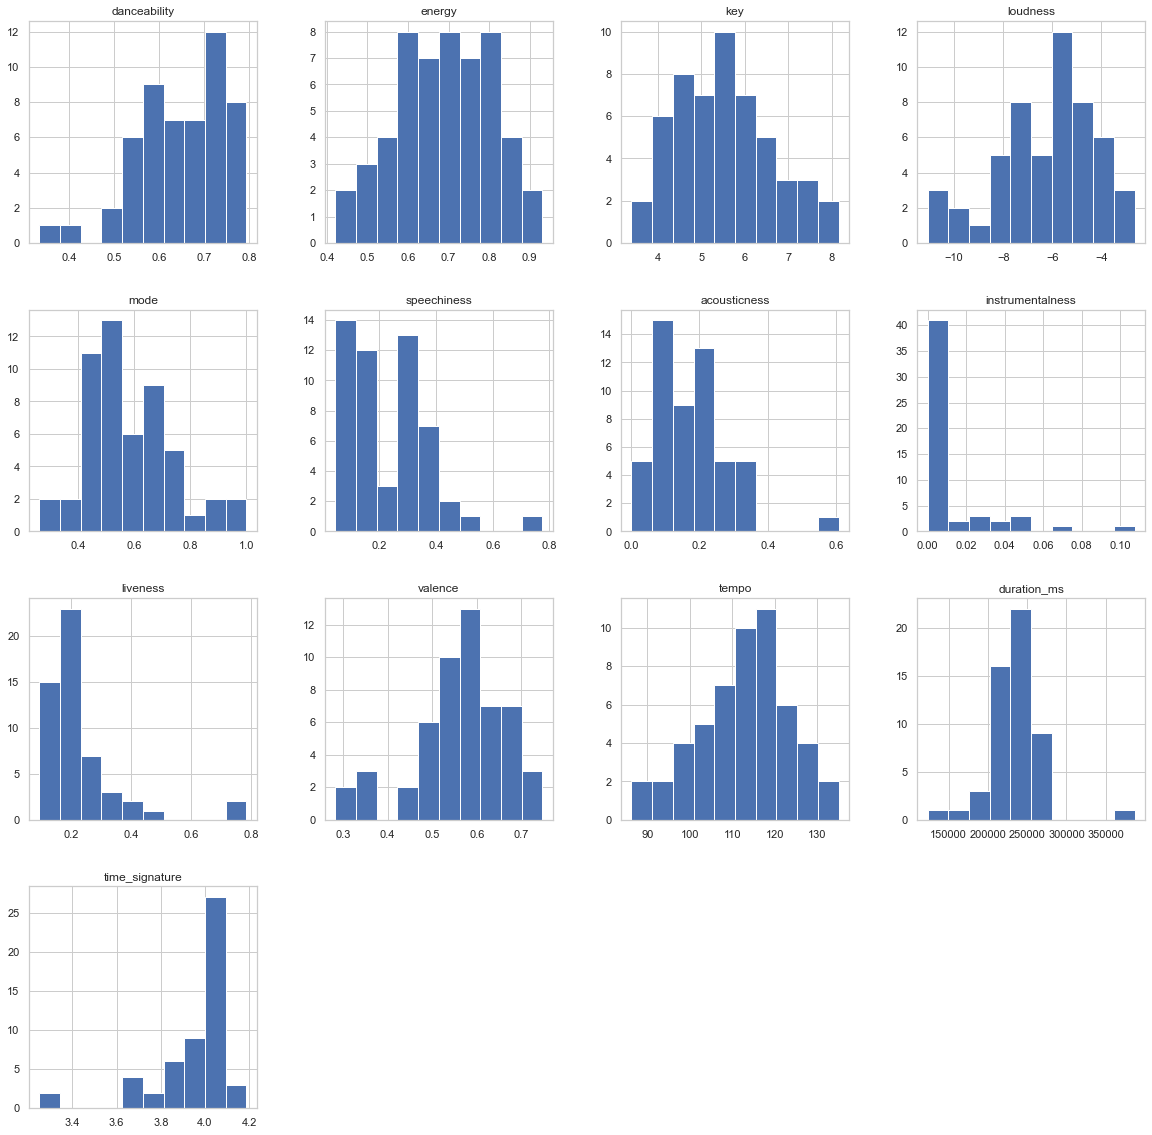

In [125]:
mean2000s.hist(figsize=(20, 20))
plt.show()

## quick view of 2010s data and all the variables

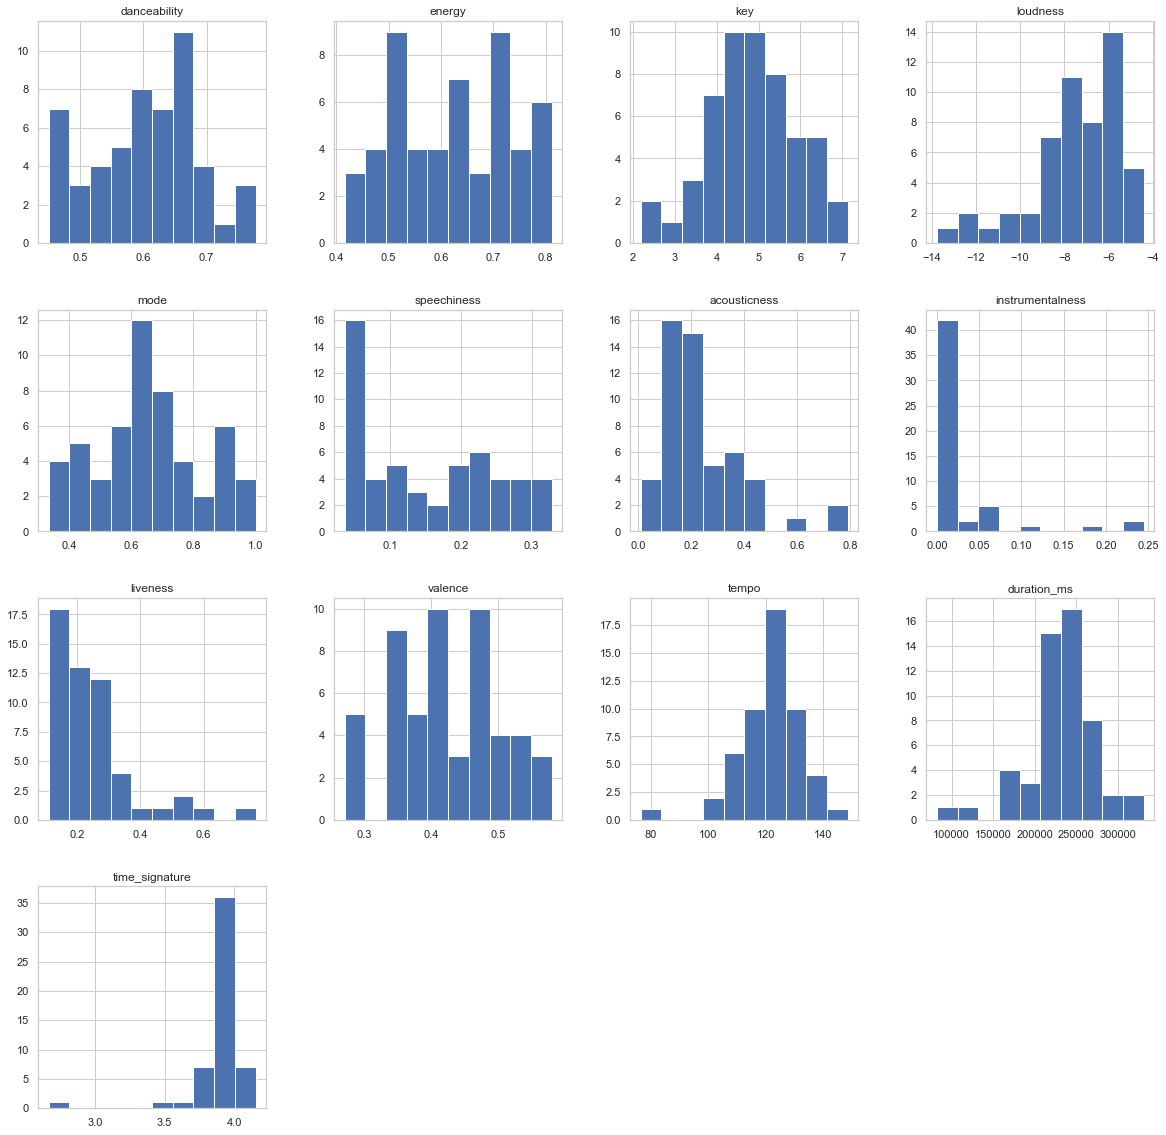

In [127]:

mean2010s.hist(figsize=(20, 20))
plt.show()

As you can see, there are differences between the 2000s data and the 2010s data! Lets do further analysis. 

## 2000s Heat Map

<AxesSubplot:>

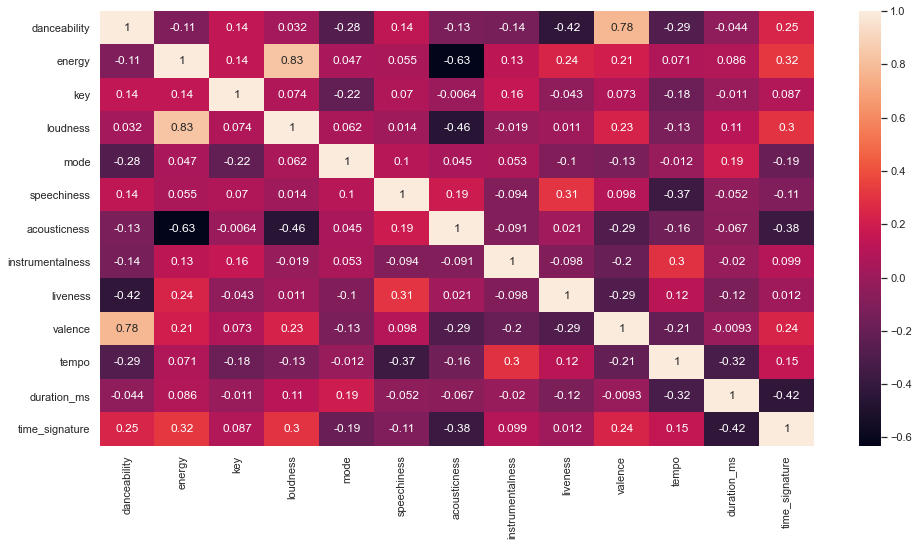

In [129]:
plt.figure(figsize=(16, 8))
sns.set(style="whitegrid")
corr = mean2000s.corr()
sns.heatmap(corr,annot=True)

## 2010s Heat Map

<AxesSubplot:>

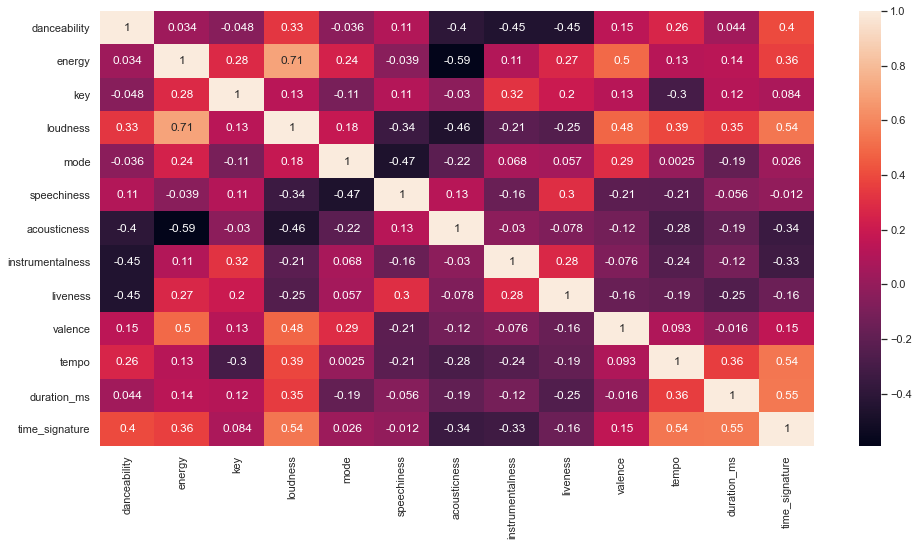

In [130]:
plt.figure(figsize=(16, 8))
sns.set(style="whitegrid")
corr = mean2010s.corr()
sns.heatmap(corr,annot=True)

Looking at these heat maps and the correlation coefficients for every variable compared to each other, we decided to do further analysis on the variables that had a correlation that had an absolute value of greater than 0.5, indicating that there is a correlation to be explored. 

### Scatterplots on variables with Correlation

The correlation of danceability vs valence is 0.78 for the 2000s data and 0.15 for the 2010s data.


Text(0.5, 1.0, 'Danceability vs Valence')

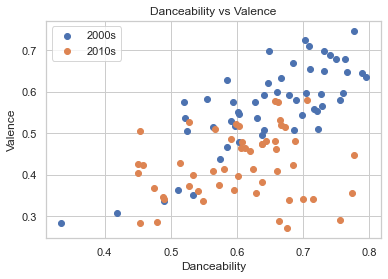

In [141]:
# danceability vs valence: corr = 0.78 on 2000s heatmap 
plt.scatter(mean2000s["danceability"], mean2000s["valence"])
plt.scatter(mean2010s["danceability"], mean2010s["valence"])
print("The correlation of danceability vs valence is 0.78 for the 2000s data and 0.15 for the 2010s data.")
plt.legend(["2000s", "2010s"])
plt.xlabel("Danceability")
plt.ylabel("Valence")
plt.title("Danceability vs Valence")

Looking at the scatterplot and the correlation coefficient, there is a postive, moderately strong, linear relationship between danceability and valence across both decades. As danceability increases, valence tends to increase as well. This might be because happier songs are more dancable to people. The songs from the 2000s seem to have an overall higher valence compared to the songs from the 2010s.

The correlation of energy vs loudness is 0.83 for the 2000s data and 0.71 for the 2010s data.


Text(0.5, 1.0, 'Energy vs Loudness')

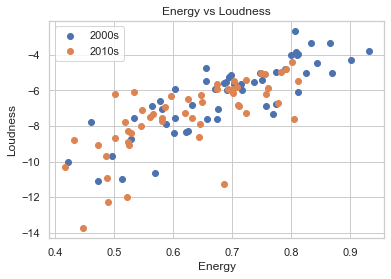

In [142]:
# energy vs loudness: corr = 0.83 on 2000s heatmap, corr = 0.71 on 2010s heatmap
plt.scatter(mean2000s["energy"], mean2000s["loudness"])
plt.scatter(mean2010s["energy"], mean2010s["loudness"])
print("The correlation of energy vs loudness is 0.83 for the 2000s data and 0.71 for the 2010s data.")
plt.legend(["2000s", "2010s"])
plt.xlabel("Energy")
plt.ylabel("Loudness")
plt.title("Energy vs Loudness")

Looking at the scatterplot and the correlation coefficient, there is a postive, moderately strong, linear relationship between energy and loudness across both decades. As energy increases, loudness tends to increase as well. This might be because energetic songs are fast and loud. 

The correlation of acousticness vs energy is -0.63 for the 2000s data and -0.59 for the 2010s data.


Text(0.5, 1.0, 'Acousticness vs Energy')

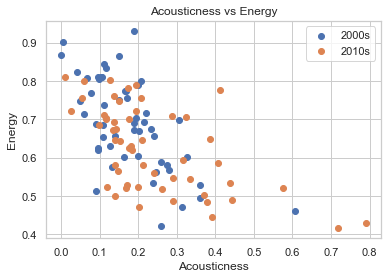

In [143]:
# acousticness vs energy: corr = -0.63 on 2000s heatmap
plt.scatter(mean2000s["acousticness"], mean2000s["energy"])
plt.scatter(mean2010s["acousticness"], mean2010s["energy"])
print("The correlation of acousticness vs energy is -0.63 for the 2000s data and -0.59 for the 2010s data.")
plt.legend(["2000s", "2010s"])
plt.xlabel("Acousticness")
plt.ylabel("Energy")
plt.title("Acousticness vs Energy")

Looking at the scatterplot and the correlation coefficient, there is a negative, moderately strong, linear relationship between energy and acousticness across both decades. As acousticness increases, loudness tends to decrease. This might be because the more acoustic a song is, the less artificial sounding the song is, and energetic songs tend to have more noises/sounds than just relying on the acousticness. 

The correlation of energy vs valence is 0.21 for the 2000s data and 0.5 for the 2010s data.


Text(0.5, 1.0, 'Energy vs Valence')

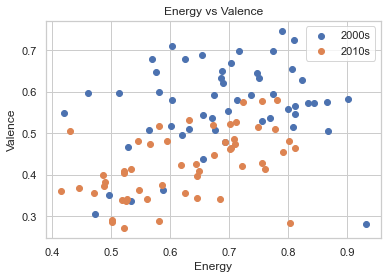

In [146]:
# energy vs valence: corr = 0.5 on 2010s heatmap
plt.scatter(mean2000s["energy"], mean2000s["valence"])
plt.scatter(mean2010s["energy"], mean2010s["valence"])
print("The correlation of energy vs valence is 0.21 for the 2000s data and 0.5 for the 2010s data.")
plt.legend(["2000s", "2010s"])
plt.xlabel("Energy")
plt.ylabel("Valence")
plt.title("Energy vs Valence")

Looking at the scatterplot and the correlation coefficient, there is a moderate, linear relationship between energy and valence, espeically in the 2010s. As energy increases, valence also tends to increase. This might be because energetic songs sound happier and more joyful. Overall, songs from the 2010s seem to be marked by lower valence points than songs from the 2000s, which means that songs tend to be less happy in the 2010s. 

The correlation of loudness vs time signature is 0.3 for the 2000s data and 0.54 for the 2010s data.


Text(0.5, 1.0, 'Loudness vs time signature')

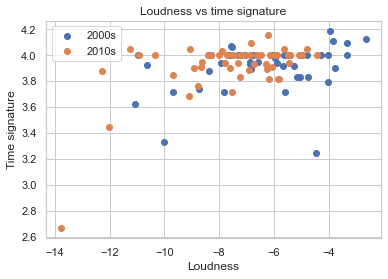

In [147]:
# loudness vs time signature: corr = 0.54 on 2010s heatmap
plt.scatter(mean2000s["loudness"], mean2000s["time_signature"])
plt.scatter(mean2010s["loudness"], mean2010s["time_signature"])
print("The correlation of loudness vs time signature is 0.3 for the 2000s data and 0.54 for the 2010s data.")
plt.legend(["2000s", "2010s"])
plt.xlabel("Loudness")
plt.ylabel("Time signature")
plt.title("Loudness vs time signature")

Looking at the scatterplot and the correlation coefficient, we can see that the most common time signature for songs from both the 2000s and the 2010s is 4.0, which is 4/4 time. This explains the relatively high correlation coefficent. Songs from 2000s tend to be louder than songs from the 2010s. 

The correlation of tempo vs time signature is 0.15 for the 2000s data and 0.54 for the 2010s data.


Text(0.5, 1.0, 'Tempo vs time signature')

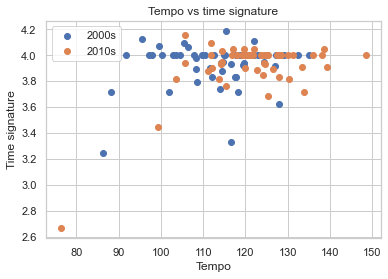

In [148]:
# tempo vs time signature: corr = 0.54 on 2010s heatmap
plt.scatter(mean2000s["tempo"], mean2000s["time_signature"])
plt.scatter(mean2010s["tempo"], mean2010s["time_signature"])
print("The correlation of tempo vs time signature is 0.15 for the 2000s data and 0.54 for the 2010s data.")
plt.legend(["2000s", "2010s"])
plt.xlabel("Tempo")
plt.ylabel("Time signature")
plt.title("Tempo vs time signature")

Looking at the scatterplot and the correlation coefficient, we can see that the most common time signature for songs from both the 2000s and the 2010s is 4.0, which is 4/4 time. This explains the relatively high correlation coefficent. Songs from the 2010s tend to have higher tempos than songs from the 2000s. 

The correlation of duration vs time signature is -0.42 for the 2000s data and 0.54 for the 2010s data.


Text(0.5, 1.0, 'Duration vs time signature')

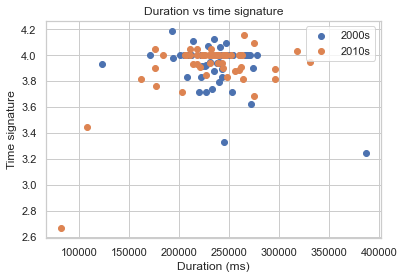

In [149]:
# duration vs time signature: corr = 0.55 on 2010s heatmap
plt.scatter(mean2000s["duration_ms"], mean2000s["time_signature"])
plt.scatter(mean2010s["duration_ms"], mean2010s["time_signature"])
print("The correlation of duration vs time signature is -0.42 for the 2000s data and 0.54 for the 2010s data.")
plt.legend(["2000s", "2010s"])
plt.xlabel("Duration (ms)")
plt.ylabel("Time signature")
plt.title("Duration vs time signature")

Looking at the scatterplot and the correlation coefficient, we can see that the most common time signature for songs from both the 2000s and the 2010s is 4.0, which is 4/4 time. This explains the relatively high correlation coefficent. Songs from the 2000s and 2010s seem to have about the same duration, disregarding the outliers for both sets of data.

### Hypothesis Testing

To analyze the differences between the two decades more in depth, we can run a difference in means hypothesis test on the 2000s data and the 2010s data to see if there is a significant difference in the characteristics from each decade. We ran these hypothesis tests with a confidence level of 0.95 (alpha = 0.05). The null hypothesis is that there is no difference between the characteristics across the two decades, and the alternative hypothesis is that there is a difference between the characterisitcs across the two decades. 

In [182]:
def hypothesis_test(df1, df2, char): 
    arraydf1 = df1[char]
    arraydf2 = df2[char]
    test = ttest_ind(arraydf1, arraydf2)
    # return p-value
    return test[1]

In [190]:
# duration 
print("The p-value is {:.3f}, so there is no significant difference in song durations between the two decades."
      .format(hypothesis_test(mean2000s, mean2010s, "duration_ms")))

The p-value is 0.493, so there is no significant difference in song durations between the two decades.


In [188]:
# key
print("The p-value is {:.3f}, so there is a significant difference in keys between the two decades."
      .format(hypothesis_test(mean2000s, mean2010s, "key")))

The p-value is 0.002, so there is a significant difference in keys between the two decades.


In [192]:
# mode 
print("The p-value is {:.3f}, so there is a significant difference in modes between the two decades."
      .format(hypothesis_test(mean2000s, mean2010s, "mode")))

The p-value is 0.011, so there is a significant difference in modes between the two decades.


In [194]:
# time signature 
print("The p-value is {:.3f}, so there is no significant difference in time signatures between the two decades."
      .format(hypothesis_test(mean2000s, mean2010s, "time_signature")))

The p-value is 0.858, so there is no significant difference in time signatures between the two decades.


In [195]:
# acousticness 
print("The p-value is {:.3f}, so there is a significant difference in acousticness between the two decades."
      .format(hypothesis_test(mean2000s, mean2010s, "acousticness")))

The p-value is 0.020, so there is a significant difference in modes between the two decades.


In [196]:
# danceability 
print("The p-value is {:.3f}, so there is a significant difference in danceability between the two decades."
      .format(hypothesis_test(mean2000s, mean2010s, "danceability")))

The p-value is 0.017, so there is a significant difference in danceability between the two decades.


In [197]:
# energy 
print("The p-value is {:.3f}, so there is a significant difference in energy between the two decades."
      .format(hypothesis_test(mean2000s, mean2010s, "energy")))

The p-value is 0.004, so there is a significant difference in energy between the two decades.


In [199]:
# instrumentalness 
print("The p-value is {:.3f}, so there is not a significant difference in instrumentalness between the two decades."
      .format(hypothesis_test(mean2000s, mean2010s, "instrumentalness")))

The p-value is 0.130, so there is not a significant difference in instrumentalness between the two decades.


In [201]:
# liveness
print("The p-value is {:.3f}, so there is not a significant difference in liveness between the two decades."
      .format(hypothesis_test(mean2000s, mean2010s, "liveness")))

The p-value is 0.626, so there is not a significant difference in liveness between the two decades.


In [202]:
# loudness 
print("The p-value is {:.3f}, so there is a significant difference in loudness between the two decades."
      .format(hypothesis_test(mean2000s, mean2010s, "loudness")))

The p-value is 0.005, so there is a significant difference in loudness between the two decades.


In [203]:
# speechiness 
print("The p-value is {:.3f}, so there is a significant difference in speechiness between the two decades."
      .format(hypothesis_test(mean2000s, mean2010s, "speechiness")))

The p-value is 0.002, so there is a significant difference in speechiness between the two decades.


In [212]:
# valence
print("The p-value is {:.14f}, so there is a significant difference in valence between the two decades."
      .format(hypothesis_test(mean2000s, mean2010s, "valence")))

The p-value is 0.00000000000527, so there is a significant difference in valence between the two decades.


In [214]:
# tempo 
print("The p-value is {:.6f}, so there is a significant difference in tempo between the two decades."
      .format(hypothesis_test(mean2000s, mean2010s, "tempo")))

The p-value is 0.000263, so there is a significant difference in tempo between the two decades.


The characteristics that changed across the two decades were key, mode, acousticness, danceability, energy, loudness, speechiness, valence, and tempo. 

We decided to graph these variables and their change over time to further our analysis. 

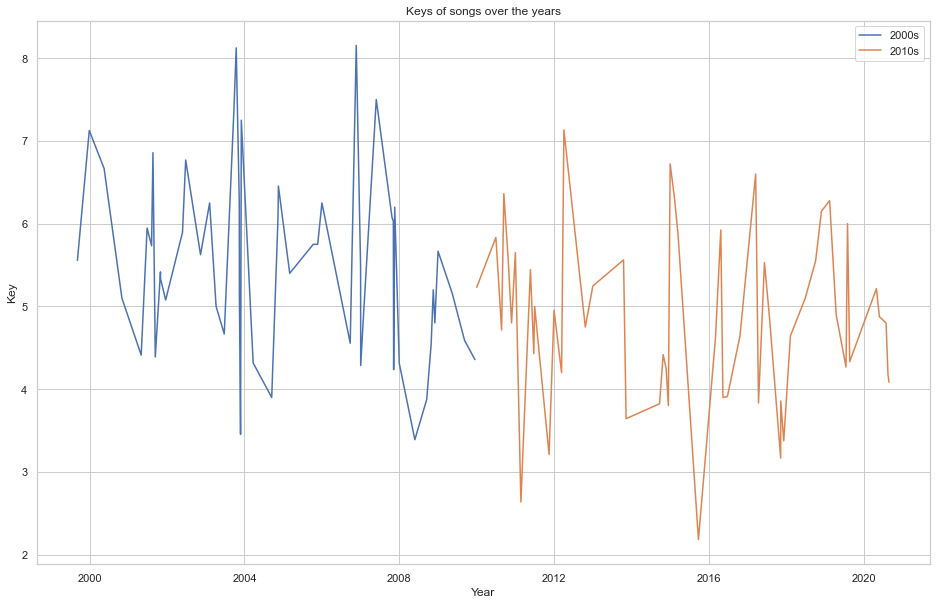

In [215]:
plt.figure(figsize=(16, 10))
sns.set(style="whitegrid")
columns = ["key"]
for col in columns:
    x1 = mean2000s.groupby("release_date")[col].mean()
    ax= sns.lineplot(x=x1.index,y=x1,label=col)
    x2 = mean2010s.groupby("release_date")[col].mean()
    ax= sns.lineplot(x=x2.index,y=x2,label=col)
ax.set_title('Keys of songs over the years')
ax.set_ylabel('Key')
ax.set_xlabel('Year')
ax.legend(["2000s", "2010s"])

In the 2010s decade, songs tended to have key values closer to 0, indicating that the songs in this decade had overall keys closer to C. 

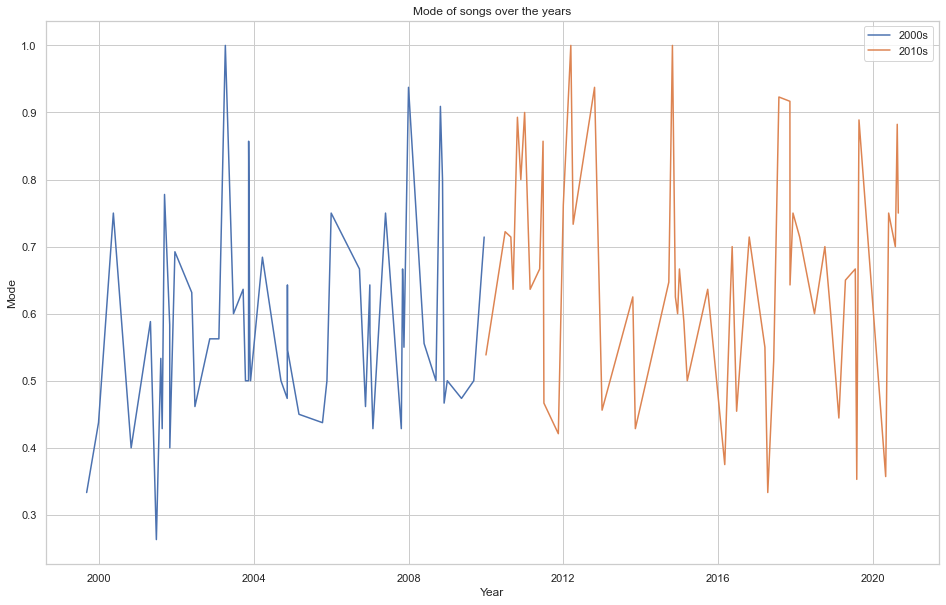

In [216]:
plt.figure(figsize=(16, 10))
sns.set(style="whitegrid")
columns = ["mode"]
for col in columns:
    x1 = mean2000s.groupby("release_date")[col].mean()
    ax= sns.lineplot(x=x1.index,y=x1,label=col)
    x2 = mean2010s.groupby("release_date")[col].mean()
    ax= sns.lineplot(x=x2.index,y=x2,label=col)
ax.set_title('Mode of songs over the years')
ax.set_ylabel('Mode')
ax.set_xlabel('Year')
ax.legend(["2000s", "2010s"])

In the 2010s decade, songs tended to be more in major keys than in minor keys as indicated by the average mode of the 2010s being closer to 1. 

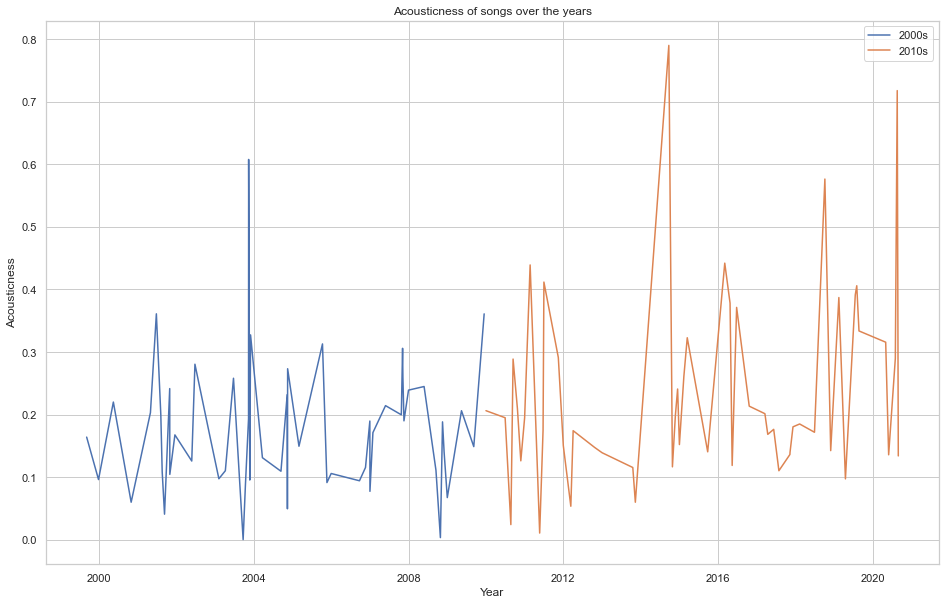

In [217]:
plt.figure(figsize=(16, 10))
sns.set(style="whitegrid")
columns = ["acousticness"]
for col in columns:
    x1 = mean2000s.groupby("release_date")[col].mean()
    ax= sns.lineplot(x=x1.index,y=x1,label=col)
    x2 = mean2010s.groupby("release_date")[col].mean()
    ax= sns.lineplot(x=x2.index,y=x2,label=col)
ax.set_title('Acousticness of songs over the years')
ax.set_ylabel('Acousticness')
ax.set_xlabel('Year')
ax.legend(["2000s", "2010s"])

In the 2010s decade, songs tended to be more acoustic, as the average acousticness value was greater in that decade. 

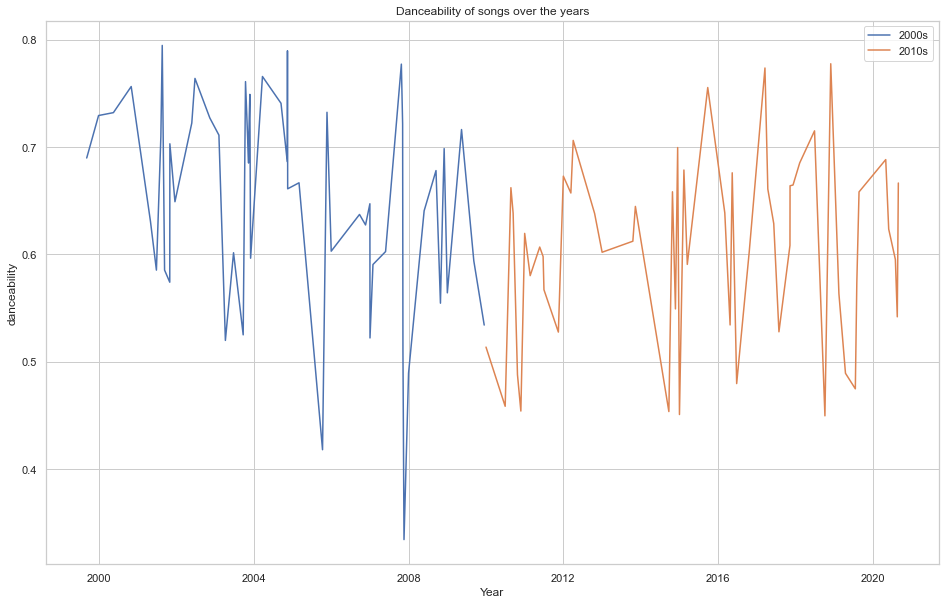

In [218]:
plt.figure(figsize=(16, 10))
sns.set(style="whitegrid")
columns = ["danceability"]
for col in columns:
    x1 = mean2000s.groupby("release_date")[col].mean()
    ax= sns.lineplot(x=x1.index,y=x1,label=col)
    x2 = mean2010s.groupby("release_date")[col].mean()
    ax= sns.lineplot(x=x2.index,y=x2,label=col)
ax.set_title('Danceability of songs over the years')
ax.set_ylabel('danceability')
ax.set_xlabel('Year')
ax.legend(["2000s", "2010s"])

In the 2010s data, songs tended to be more danceable, given that the average danceability value was higher for that era. However, there does seem to be an outlier on the low end for the 2000s decade.

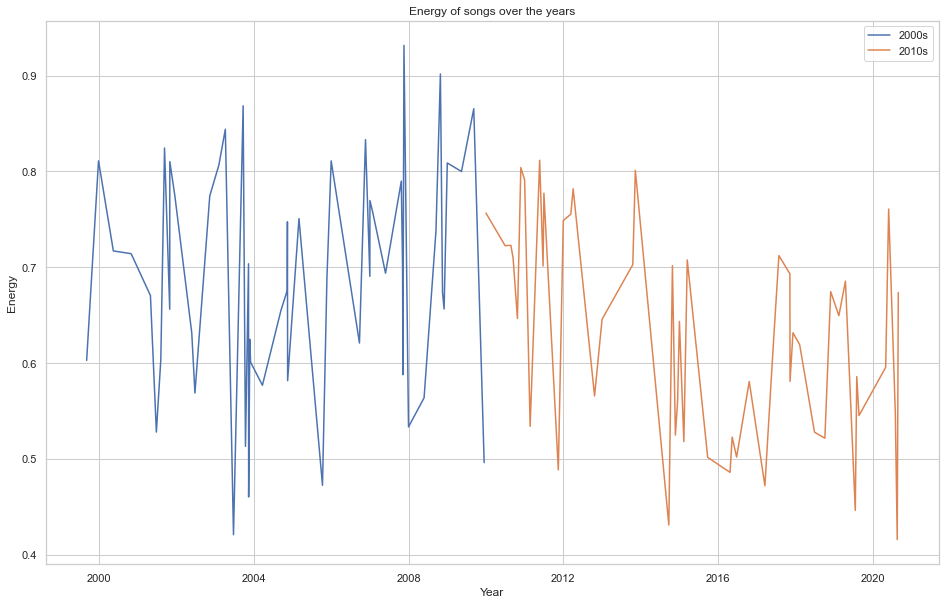

In [219]:
plt.figure(figsize=(16, 10))
sns.set(style="whitegrid")
columns = ["energy"]
for col in columns:
    x1 = mean2000s.groupby("release_date")[col].mean()
    ax= sns.lineplot(x=x1.index,y=x1,label=col)
    x2 = mean2010s.groupby("release_date")[col].mean()
    ax= sns.lineplot(x=x2.index,y=x2,label=col)
ax.set_title('Energy of songs over the years')
ax.set_ylabel('Energy')
ax.set_xlabel('Year')
ax.legend(["2000s", "2010s"])

In the 2010s era, songs tended to be less energetic, as indicated by the lower average energy values. 

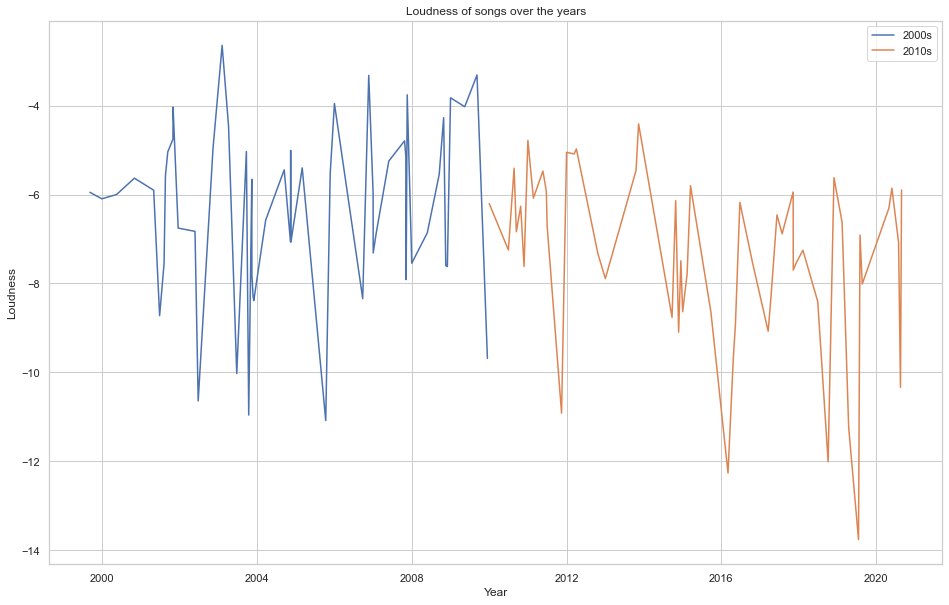

In [220]:
plt.figure(figsize=(16, 10))
sns.set(style="whitegrid")
columns = ["loudness"]
for col in columns:
    x1 = mean2000s.groupby("release_date")[col].mean()
    ax= sns.lineplot(x=x1.index,y=x1,label=col)
    x2 = mean2010s.groupby("release_date")[col].mean()
    ax= sns.lineplot(x=x2.index,y=x2,label=col)
ax.set_title('Loudness of songs over the years')
ax.set_ylabel('Loudness')
ax.set_xlabel('Year')
ax.legend(["2000s", "2010s"])

In the 2010s, songs tended to be less loud, as indicated by the lower average loudness value.

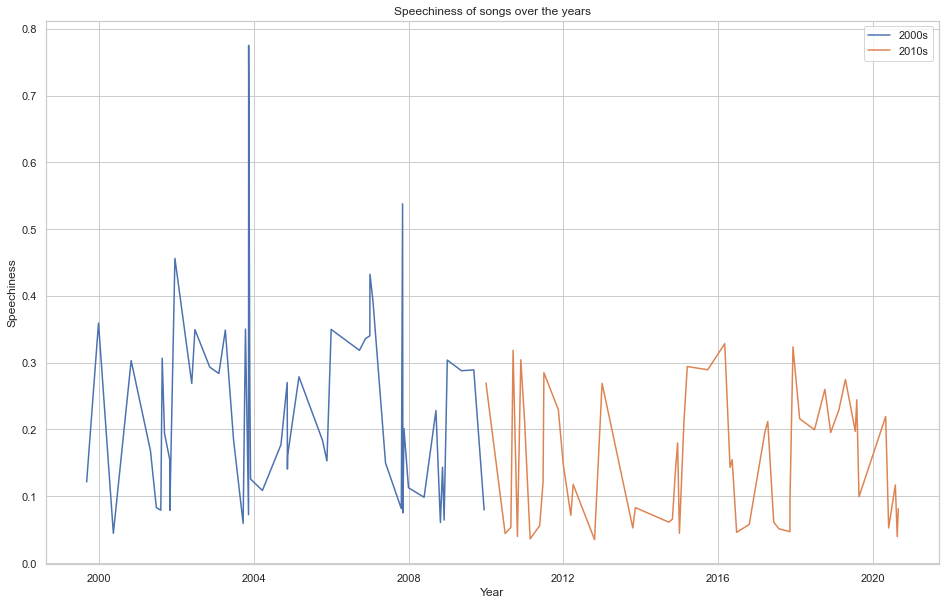

In [221]:
plt.figure(figsize=(16, 10))
sns.set(style="whitegrid")
columns = ["speechiness"]
for col in columns:
    x1 = mean2000s.groupby("release_date")[col].mean()
    ax= sns.lineplot(x=x1.index,y=x1,label=col)
    x2 = mean2010s.groupby("release_date")[col].mean()
    ax= sns.lineplot(x=x2.index,y=x2,label=col)
ax.set_title('Speechiness of songs over the years')
ax.set_ylabel('Speechiness')
ax.set_xlabel('Year')
ax.legend(["2000s", "2010s"])

In the 2010s era, songs tended to be less speechy, as indicated by the lower average speechiness value. It should be noted that there is an outlier on the high end for the 2000s data. 

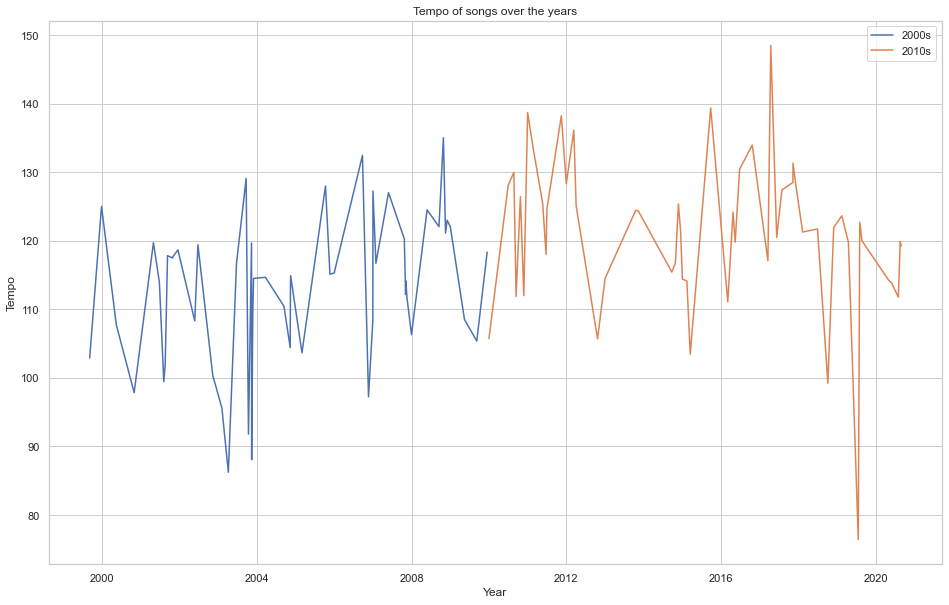

In [222]:
plt.figure(figsize=(16, 10))
sns.set(style="whitegrid")
columns = ["tempo"]
for col in columns:
    x1 = mean2000s.groupby("release_date")[col].mean()
    ax= sns.lineplot(x=x1.index,y=x1,label=col)
    x2 = mean2010s.groupby("release_date")[col].mean()
    ax= sns.lineplot(x=x2.index,y=x2,label=col)
ax.set_title('Tempo of songs over the years')
ax.set_ylabel('Tempo')
ax.set_xlabel('Year')
ax.legend(["2000s", "2010s"])

In the 2010s era, songs tended have a higher tempo, as indicated by the higher average tempo value. It should be noted that there is an outlier for the 2010s songs on the lower end. 

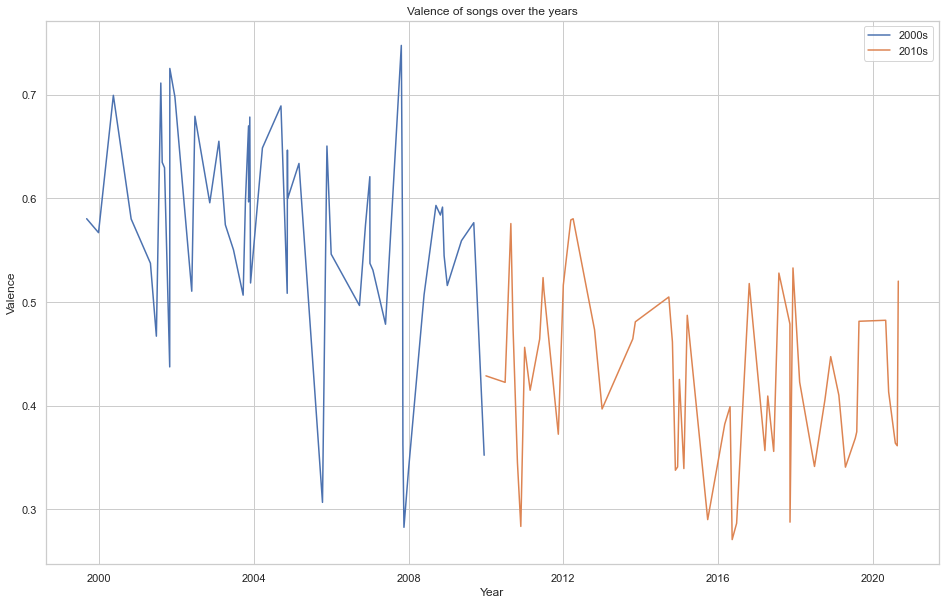

In [223]:
plt.figure(figsize=(16, 10))
sns.set(style="whitegrid")
columns = ["valence"]
for col in columns:
    x1 = mean2000s.groupby("release_date")[col].mean()
    ax= sns.lineplot(x=x1.index,y=x1,label=col)
    x2 = mean2010s.groupby("release_date")[col].mean()
    ax= sns.lineplot(x=x2.index,y=x2,label=col)
ax.set_title('Valence of songs over the years')
ax.set_ylabel('Valence')
ax.set_xlabel('Year')
ax.legend(["2000s", "2010s"])

In the 2010s era, songs tended to be more sad, as indicated by the lower average valence value. 

# Pre-registered Analyses 

We wanted to further explore our data to see if there were other correlations between other variables. 

## Analysis 1:

We will plot our data and cluster based on the decade that the song was released. Then we can analyze if there is any association between danceability and tempo. We graphed danceability vs tempo below.

The correlation of danceability vs tempo is -0.29 for the 2000s data and 0.26 for the 2010s data.


Text(0.5, 1.0, 'Danceability vs tempo')

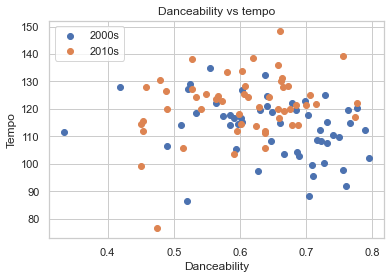

In [151]:
plt.scatter(mean2000s["danceability"], mean2000s["tempo"])
plt.scatter(mean2010s["danceability"], mean2010s["tempo"])
print("The correlation of danceability vs tempo is -0.29 for the 2000s data and 0.26 for the 2010s data.")
plt.legend(["2000s", "2010s"])
plt.xlabel("Danceability")
plt.ylabel("Tempo")
plt.title("Danceability vs tempo")

There is not a strong correlation between danceability and tempo in the songs from both decades. This might be because other variables are more prominent in affecting the danceability and tempo of a song. 

## Analysis 2:

We want to plot the tempo of the song against time to analyze how trends have changed.

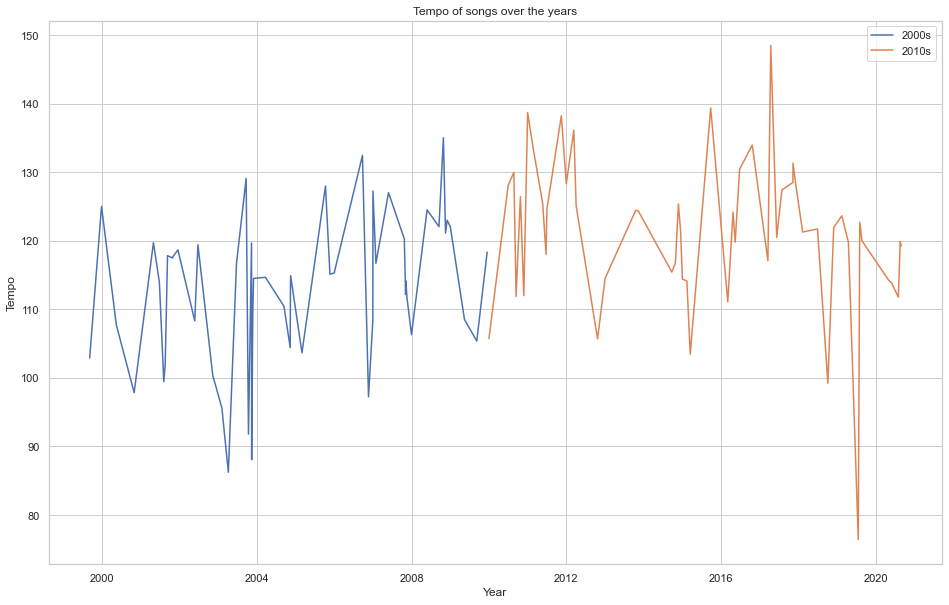

In [160]:
plt.figure(figsize=(16, 10))
sns.set(style="whitegrid")
columns = ["tempo"]
for col in columns:
    x1 = mean2000s.groupby("release_date")[col].mean()
    ax= sns.lineplot(x=x1.index,y=x1,label=col)
    x2 = mean2010s.groupby("release_date")[col].mean()
    ax= sns.lineplot(x=x2.index,y=x2,label=col)
ax.set_title('Tempo of songs over the years')
ax.set_ylabel('Tempo')
ax.set_xlabel('Year')
ax.legend(["2000s", "2010s"])

Overall, the tempos of songs from both decades generally stayed the same (around 110-120). It can be noted that more risks were taken in the tempos of songs from the 2010s, as there were a wider range of tempos.

## Analysis 3:

We want to plot the valence of the song against time to analyze how trends have changed through the decades, as valence is a measure of happiness.

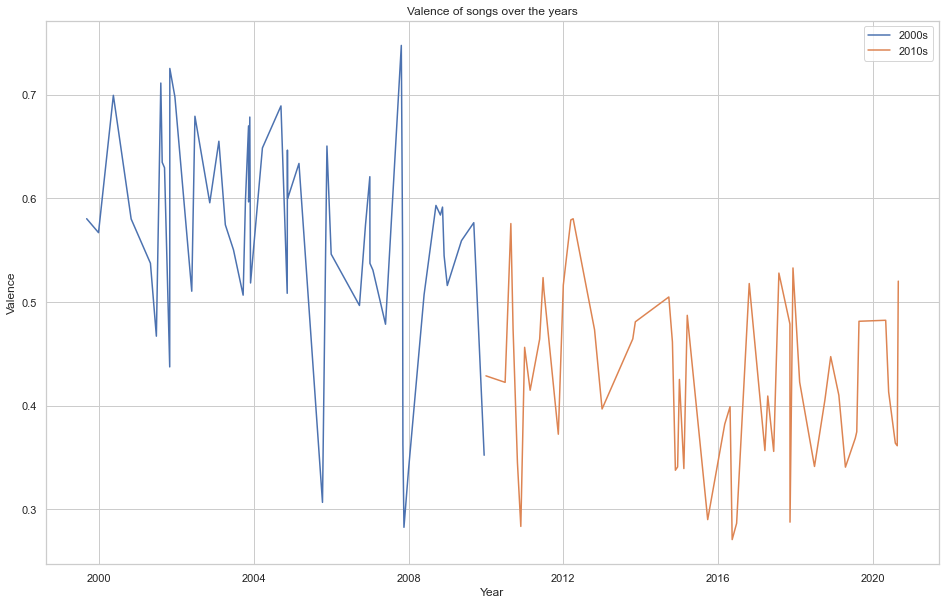

In [161]:
plt.figure(figsize=(16, 10))
sns.set(style="whitegrid")
columns = ["valence"]
for col in columns:
    x1 = mean2000s.groupby("release_date")[col].mean()
    ax= sns.lineplot(x=x1.index,y=x1,label=col)
    x2 = mean2010s.groupby("release_date")[col].mean()
    ax= sns.lineplot(x=x2.index,y=x2,label=col)
ax.set_title('Valence of songs over the years')
ax.set_ylabel('Valence')
ax.set_xlabel('Year')
ax.legend(["2000s", "2010s"])

Generally, the songs from the 2010s were lower in valence, indicating that these songs were sadder. This implies that sadder music is trendier in the 2010 decade than in the 2000s.

# Conclusion

Over the course of our data analysis, we compared music from the 2000s and the 2010s based on valence (happy mood), major/minor keys, tempos, speech, acousticness, and danceability. We first scraped our data from the Spotify API by looking at the top 10 artists from each decade. We cleaned and combined this data into one large dataframe so that we would be able to further analyze it in our next step.

We first provided a quick view of all of our current data through histograms and heat maps. Then, we began comparing variables between the two decades, such as energy versus loudness or tempo versus time signature. With each pair, we also analyzed the correlation coefficient of each decade.

From here, we went onto hypothesis testing to find out if the differences of these attributes between songs from the two decades were significant or not. We found that there was a significant difference in key, mode, acoustic ness, danceability, energy, loudness, speechiness, valence, and tempo between the two decades. To further analyze these specific characteristics, we graphed them against time to see how they had changed from the 2000s to the 2010s.

This is where we found that:
- In the 2010s decade, songs tended to have less valence, meaining they sounded overall less happy
- In the 2010s decade, songs tended to be more in minor keys
- In the 2010s era, songs tended have a higher tempo, as indicated by the higher average tempo value.
- In the 2010s era, songs tended to be less speechy
- In the 2010s decade, songs tended to be more acoustic, more raw instrumentals
- In the 2010s decade, songs tended to be more danceable

After creating these trend plots, we plotted the data and clustered it based on the decade the song was released for further analysis. We also plotted the tempo of the song against time to see how trends had changed. In addition, we did the same with valence and found that valence has decreased over time, implying that sadder music is trendier and more prominent in the 2010s compared to the 2000s.

We were very satisfied in discovering these interesting results about the music industry throughout the semester. Lots of these findings make sense and could be used for recording companies or music artists who are trying to create popular hit songs. They would want to know what types of songs have been trendier lately, and looking at our data, they would want to write a minor key, higher tempo, less speechy, more acoustic, and more danceable song to appeal to more people.


## Limitations

In this dataset, there are extremely specific definitions for how Spotify calculated metrics for each song like ‘danceability’, ‘acousticness’, and ‘liveliness’. We had no control over the metrics Spotify used to obtain these values for these tracks.

Although we are pulling data from the most popular artists of the decades, which gives us a good representation of what the music trends were at the time, it doesn't necessarily represent the music industry as a whole from these two decades. 

As a project, we based lots of our findings off the fact that the music present on Spotify (and from the top 10 artists at the time) was representative of the music industry during the 2000s and the 2010s when Spotify was not as well known in the 2000s. However, we hope that this assumption still holds because Spotify has an extremely large database with music dating back to the late 1800s.

# Acknowledgements

To finish this project, we used a few outside sources and would like to thank them:

We relied on Billboard.com to define what artists made up the decade for boths the 2000s and 2010s.

We used Steven Morse's blog on how to properly use the Spotify API to scrape data and what useful tests can be done.

We also want to thank Professor Mimno for the useful information during his lectures of how to scrap and analyze data, as well at the TAs who helped us during office hours!